In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [2]:
file = open('cv_df_extracted', 'rb')
cv_df = pickle.load(file)

In [3]:
# # change all values in CHROM into consistent datatype
# cv_df['CHROM'] = cv_df['CHROM'].apply(lambda x: str(x))

In [4]:
# Extract columns to be pushed into model
prog_df = cv_df[['CLNSIG','AF_ESP','AF_EXAC','AF_TGP','CADD_RAW','BLOSUM62','LoFtool','PolyPhen','SIFT']]

In [5]:
# Clean and fill in missing values. BLOSUM62 missing values automatically mean 0. 
prog_df.loc[prog_df['BLOSUM62'] == '', ['BLOSUM62']] = '0'
prog_df.loc[prog_df['CADD_RAW'] == '', ['CADD_RAW']] = '0'
prog_df.loc[prog_df['AF_ESP'] == '', ['AF_ESP']] = '0'
prog_df.loc[prog_df['AF_EXAC'] == '', ['AF_EXAC']] = '0'
prog_df.loc[prog_df['AF_TGP'] == '', ['AF_TGP']] = '0'
prog_df.loc[prog_df['LoFtool'] == '', ['LoFtool']] = 'NaN'
prog_df.loc[prog_df['PolyPhen'] == '', ['PolyPhen']] = 'unknown'
prog_df.loc[prog_df['SIFT'] == '', ['SIFT']] = 'NaN'

prog_df['AF_ESP'].fillna(0, inplace=True)
prog_df['AF_EXAC'].fillna(0, inplace=True)
prog_df['AF_TGP'].fillna(0, inplace=True)


In [6]:
prog_df = prog_df.astype({
    'CADD_RAW': 'float', 
    'BLOSUM62': 'int64',
    'AF_ESP': 'float',
    'AF_EXAC': 'float',
    'AF_TGP': 'float',
    'LoFtool': 'float'})

## FINALLY MODELLING!

In [7]:
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [8]:
prog_df['CLNSIG'].value_counts()

Benign_cat                    28086
Uncertain_significance_cat    17223
Pathogenic_cat                12354
Name: CLNSIG, dtype: int64

In [9]:
# Get dummies and train_test_split
X = prog_df[['AF_ESP','AF_EXAC','AF_TGP','CADD_RAW','BLOSUM62','LoFtool','PolyPhen','SIFT']]
y = prog_df['CLNSIG']

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
X.dtypes

AF_ESP                             float64
AF_EXAC                            float64
AF_TGP                             float64
CADD_RAW                           float64
BLOSUM62                             int64
LoFtool                            float64
PolyPhen_benign                      uint8
PolyPhen_possibly_damaging           uint8
PolyPhen_probably_damaging           uint8
PolyPhen_unknown                     uint8
SIFT_NaN                             uint8
SIFT_deleterious                     uint8
SIFT_deleterious_low_confidence      uint8
SIFT_tolerated                       uint8
SIFT_tolerated_low_confidence        uint8
dtype: object

In [11]:
# Default xgboost classifier (two cells below)
import xgboost as xgb
xg_clas = xgb.XGBClassifier()

xg_clas.fit(X_train, y_train)
xg_clas.score(X_test, y_test)

0.8947368421052632

Text(33.0, 0.5, 'Actual')

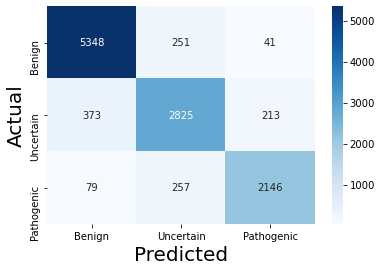

In [12]:
from sklearn.metrics import confusion_matrix

y_pred = xg_clas.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
#Swap rows 2,3 and columns 2,3, for better understanding
cf_matrix[[1,2]] = cf_matrix[[2,1]]
cf_matrix[:, [1, 2]] = cf_matrix[:, [2, 1]]

import seaborn as sns
columns = ['Benign','Uncertain','Pathogenic']
ax = sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels = columns, yticklabels = columns)
plt.xlabel("Predicted", fontsize = 20)
plt.ylabel("Actual", fontsize = 20)

In [13]:
y_test.value_counts()

Benign_cat                    5640
Uncertain_significance_cat    3411
Pathogenic_cat                2482
Name: CLNSIG, dtype: int64

In [14]:
# pickle dump the models

curr_model = eval('xg_clas')
curr_model.fit(X_train, y_train)
with open("models/xgboost.pickle", "wb") as pfile:
    pickle.dump(curr_model, pfile)